In [1]:

import matplotlib.pyplot as plt
import numpy as np
import math
import torch

from BayesianRegression import BayesianLinearRegression
%matplotlib inline

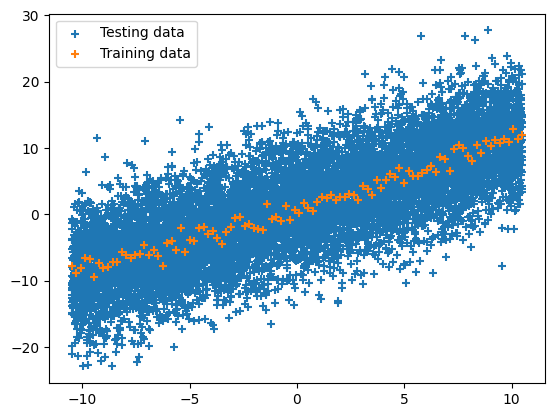

In [2]:
from random_data_generator import masegosa_sampleData
torch.manual_seed(2)
np.random.seed(1)
x_test,y_test = masegosa_sampleData(10000,5)

torch.manual_seed(1)
np.random.seed(0)
x_train,y_train = masegosa_sampleData(100,1)
plt.scatter(x_test[:,1], y_test, marker='+', label='Testing data')
plt.scatter(x_train[:,1], y_train, marker='+', label='Training data')
plt.legend()
plt.show()

In [3]:
blr_class = BayesianLinearRegression(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test, theta_samples=10, loss="ELBO")
blr_class.optimise()

ELBO: -23.007837127612262:   0%|          | 11/3000 [00:00<00:27, 106.76it/s]


calculating elbo
rsample
tensor([[1., 0.],
        [0., 1.]], grad_fn=<SliceBackward0>)
rsample
tensor([[1.]], grad_fn=<SliceBackward0>)
calculating log_q
tensor([[1., 0.],
        [0., 1.]], grad_fn=<SliceBackward0>)
tensor([[1., 0.],
        [0., 1.]], grad_fn=<SliceBackward0>)
tensor([[1., 0.],
        [0., 1.]], grad_fn=<SliceBackward0>)
tensor([[1., 0.],
        [0., 1.]], grad_fn=<SliceBackward0>)
tensor([[1., 0.],
        [0., 1.]], grad_fn=<SliceBackward0>)
tensor([[1., 0.],
        [0., 1.]], grad_fn=<SliceBackward0>)
tensor([[1., 0.],
        [0., 1.]], grad_fn=<SliceBackward0>)
tensor([[1., 0.],
        [0., 1.]], grad_fn=<SliceBackward0>)
tensor([[1., 0.],
        [0., 1.]], grad_fn=<SliceBackward0>)
tensor([[1., 0.],
        [0., 1.]], grad_fn=<SliceBackward0>)
calculating elbo
rsample
tensor([[0.8900, 0.1100],
        [0.1100, 0.8900]], grad_fn=<SliceBackward0>)
rsample
tensor([[1.]], grad_fn=<SliceBackward0>)
calculating log_q
tensor([[0.8900, 0.1100],
        [0.1100, 0

ValueError: Expected parameter covariance_matrix (Tensor of shape (1, 2, 2)) of distribution MultivariateNormal(loc: torch.Size([1, 2]), covariance_matrix: torch.Size([1, 2, 2])) to satisfy the constraint PositiveDefinite(), but found invalid values:
tensor([[[ 0.4025, -0.2384],
         [-0.2384,  0.1048]]], grad_fn=<ExpandBackward0>)

In [ ]:
blr_class = BayesianLinearRegression(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test, theta_samples=10, loss="ELBO_var")
blr_class.optimise()

ELBO: -22.0827002292189: 100%|██████████| 3000/3000 [00:08<00:00, 355.73it/s]  

beta mean: [1.08319242 1.02496863]
beta sd: [0.25549513 0.29259345]
sig mean: 0.28608410907918935 | sig sd: 0.357723002470372
Negative Log-Likelihood: -24.63139023232503


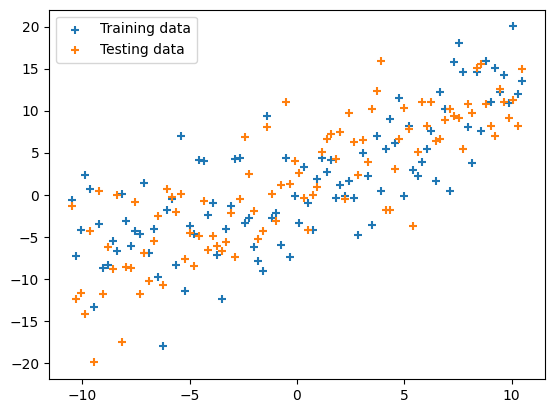

In [ ]:
from random_data_generator import masegosa_sampleData
torch.manual_seed(2)
np.random.seed(1)
x_test,y_test = masegosa_sampleData(100,5)

torch.manual_seed(1)
np.random.seed(0)
x_train,y_train = masegosa_sampleData(100,5)
plt.scatter(x_train[:,1], y_train, marker='+', label='Training data')
plt.scatter(x_test[:,1], y_test, marker='+', label='Testing data')
plt.legend()
plt.show()

In [ ]:
blr_class = BayesianLinearRegression(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test, theta_samples=10, loss="ELBO")
blr_class.optimise()

ELBO: -34.11753705519851: 100%|██████████| 3000/3000 [00:06<00:00, 498.67it/s] 

beta mean: [1.32269213 0.9690791 ]
beta sd: [1.06361902 1.86137847]
sig mean: 1.009181151073378 | sig sd: 1.2618922196008668
Negative Log-Likelihood: -21.98581507505116


In [ ]:
blr_class = BayesianLinearRegression(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test, theta_samples=10, loss="ELBO_var")
blr_class.optimise()

ELBO: -34.17469615232877: 100%|██████████| 3000/3000 [00:08<00:00, 353.11it/s] 

beta mean: [1.3231676  0.96700351]
beta sd: [0.25549513 0.29259345]
sig mean: 0.28608410907918935 | sig sd: 0.357723002470372
Negative Log-Likelihood: -21.960940029431185


In [ ]:
from tqdm import trange
from variational_distributions import VariationalNormal, VariationalMultivariateNormal
from torch.distributions import Normal, MultivariateNormal


class BayesianMVNLinearRegression:
    def __init__(self, x_data, y_data, theta_samples) -> None:
        self.x_data = x_data
        self.y_data = y_data
        self.n = self.x_data.size(0)
        self.m = self.x_data.size(1)
        self.variational_distribution =  VariationalMultivariateNormal(size=2)
        self.theta_samples = torch.Size([theta_samples])

    def log_prior(self, variational_samples):
        log_prior_beta = 0
        for beta_sample in variational_samples:
            log_prior_beta += MultivariateNormal(torch.zeros(2), torch.eye(2)).log_prob(beta_sample).sum()

        return log_prior_beta / self.theta_samples[0]

    def log_likelihood(self, variational_samples):
        loglik = []
        for beta_sample in variational_samples:
            loglik.append(
                torch.reshape(
                    Normal(self.x_data.matmul(beta_sample[0]), 1).log_prob(
                        self.y_data
                    ),
                    (-1, 1),
                )
            )
        return torch.cat(loglik, -1)

    def log_q(self, variational_samples):
        log_q_beta = 0

        for beta_sample in variational_samples:
            log_q_beta += self.variational_distribution.log_q(beta_sample[0])

        return log_q_beta / self.theta_samples[0]

    def elbo(self):
        variational_samples = self.variational_distribution.rsample(
            self.theta_samples
        )

        log_likelihood = self.log_likelihood(variational_samples).mean()
        log_prior = self.log_prior(variational_samples)
        log_posterior = self.log_q(variational_samples)

        elbo = log_likelihood - log_posterior / self.n + log_prior / self.n

        return elbo

    def optimise(self):
        optimizer = torch.optim.Adam(
            [
                self.variational_distribution.var_params
            ],
            lr=0.11,
        )
        elbo_hist = []

        max_iter = 3000
        minibatch_size = 100
        torch.manual_seed(1)

        # This basically creates a progress bar for SGD. max_iter determines the final iteration.
        # mininterval determines how often the progress bar is updated (every 1 second here).
        iters = trange(max_iter, mininterval=1)

        # Stochastic gradient descent
        for t in iters:
            sample_with_replacement = minibatch_size > self.n
            idx = np.random.choice(
                self.n, minibatch_size, replace=sample_with_replacement
            )
            loss = -self.elbo()
            elbo_hist.append(-loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Print progress bar
            iters.set_description("ELBO: {}".format(elbo_hist[-1]), refresh=False)

        nsamps = 1000
        # print('True beta: {}'.format(beta.detach().numpy()))
        print(
            "beta mean: {}".format(
                self.variational_distribution.var_params[:1].detach().numpy()
            )
        )
        print(
            "beta sd: {}".format(
                self.variational_distribution
                .var_params[1:]
                .exp()
                .detach()
                .numpy()
            )
        )

        return elbo_hist

In [ ]:
from BayesianRegression import BayesianLinearRegression


blr_class = BayesianMVNLinearRegression(x_data=x_train, y_data=y_train, theta_samples=10)
elbo_hist = blr_class.optimise()
plt.plot(elbo_hist)

ELBO: -175.2110592907982:   1%|          | 18/3000 [00:00<00:21, 140.24it/s]


ValueError: Expected parameter covariance_matrix (Tensor of shape (1, 2, 2)) of distribution MultivariateNormal(loc: torch.Size([1, 2]), covariance_matrix: torch.Size([1, 2, 2])) to satisfy the constraint PositiveDefinite(), but found invalid values:
tensor([[[ 0.6490, -1.3189],
         [-1.3189,  2.4893]]], grad_fn=<ExpandBackward0>)

In [ ]:
elbo_hist

[-560.5928950490813,
 -717.0224177200929,
 -187.2265950578243,
 -167.17059102491228,
 -99.47479358313605,
 -39.131361807894,
 -53.95090757910658,
 -30.667150577968037,
 -28.257646730698532,
 -19.152921755719863,
 -23.918286179669913,
 -14.1201532065997,
 -23.735600560486947,
 -18.82954935987188,
 -15.491545281392419,
 -18.496179250966954,
 -14.331536488490503,
 -9.279980239452406,
 -6.539766825825474,
 -9.007922068379516,
 -7.902776461572796,
 -10.780680225479776,
 -3.9160653514140273,
 -5.103305005776414,
 -6.570540734648693,
 -5.900832818356528,
 -6.450633670333194,
 -5.239652293669565,
 -6.301165587337259,
 -4.981914577263148,
 -5.9995008747894305,
 -6.228036732311633,
 -3.5994625955900315,
 -5.903137704889809,
 -4.612560970832653,
 -5.023205798562038,
 -3.4583443442172044,
 -4.3305566448845125,
 -4.642238251609718,
 -3.1251938992220656,
 -5.385686332188458,
 -4.750833811122393,
 -4.0992836509215085,
 -5.524806491509914,
 -3.3408926740084364,
 -4.107568967696729,
 -3.866433467056397